# Multilable text classification with fastai v1

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
path = Path('data')

## Prepare dataframe

In [4]:
df_trn = pd.read_csv(path/'train_Robinson.csv', skiprows=1,low_memory=False, dtype={'Contributing Factors / Situations':str})
df_val = pd.read_csv(path/'valid.csv', skiprows=1,low_memory=False, dtype={'Contributing Factors / Situations':str})
df_trn.head(5)

,ACN,Date,Local Time Of Day,Locale Reference,State Reference,Relative Position.Angle.Radial,Relative Position.Distance.Nautical Miles,Altitude.AGL.Single Value,Altitude.MSL.Single Value,Flight Conditions,...,When Detected,Result,Contributing Factors / Situations,Primary Problem,Narrative,Callback,Narrative.1,Callback.1,Synopsis,Unnamed: 96
0,925545,201101,0001-0600,ZNY.ARTCC,NY,NaN,NaN,NaN,19000.0,NaN,...,NaN,Air Traffic Control Issued New Clearance,Aircraft; Equipment / Tooling; Human Factors,Human Factors,[I was] working air carrier 1 at FL190. Sector...,NaN,Air carrier 1 [was] being worked by Sector 56 ...,NaN,ZNY controllers and flight crew personnel desc...,NaN
1,925560,201101,1201-1800,ZZZ.Tower,US,NaN,NaN,0.0,NaN,NaN,...,Taxi,Air Traffic Control Issued New Clearance; Air ...,Human Factors,Human Factors,Aircraft X; a CRJ2; landed Runway XXL and was ...,NaN,NaN,NaN,Disabled aircraft causes airport authority to ...,NaN
2,925563,201101,1201-1800,ZOB.ARTCC,OH,NaN,NaN,NaN,15000.0,NaN,...,In-flight,Air Traffic Control Issued New Clearance; Air ...,Human Factors; Procedure; Staffing,Human Factors,I was working combined sectors with no D-side....,NaN,NaN,NaN,ZOB Controller reported that when an aircraft ...,NaN
3,925810,201101,0001-0600,ZZZ.Airport,US,NaN,NaN,0.0,NaN,NaN,...,Aircraft In Service At Gate,Flight Crew Returned To Gate; General Maintena...,Procedure; Human Factors; Aircraft; Staffing; ...,Aircraft,[We] arrived to a cold airplane with ambient t...,NaN,NaN,NaN,A CRJ flight crew suffered a hot start on a fi...,NaN
4,925811,201101,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,32500.0,IMC,...,In-flight,Air Traffic Control Provided Assistance; Aircr...,Aircraft; Weather,Aircraft,During the climbout we entered the ragged over...,NaN,NaN,NaN,B717 Captain experienced simultaneous overspee...,NaN


In [5]:
df_trn.shape, df_val.shape

((4500, 97), (2948, 97))

In [9]:
df_trn.dropna(axis=0, subset=['Contributing Factors / Situations'], inplace=True)
df_val.dropna(axis=0, subset=['Contributing Factors / Situations'], inplace=True)

In [10]:
len(df_trn), len(df_val)

(4485, 2935)

In [11]:
# Replace label delimiter '; ' by single char '|' to allow compatibility with fastai 1.0.28

df_trn['Contributing Factors / Situations'] = df_trn['Contributing Factors / Situations'].str.replace('; ', '|').astype(str)

df_val['Contributing Factors / Situations'] = df_val['Contributing Factors / Situations'].str.replace('; ', '|').astype(str)


## Language model

Fine tune the language model

In [12]:
df = pd.concat([df_trn, df_val], ignore_index=True)

In [13]:
bs = 48

In [14]:
data_lm = (TextList.from_df(df, path, cols='Narrative')
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

In [15]:
data_lm.save('tmp_lm')

In [16]:
learn_lm = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


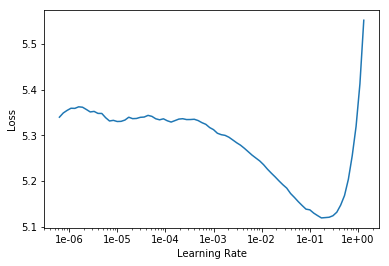

In [18]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=10)

In [19]:
learn_lm.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 00:47
epoch  train_loss  valid_loss  accuracy
1      4.108119    3.942737    0.276310  (00:47)



In [20]:
learn_lm.save('fit_head')

In [ ]:
learn_lm.load('fit_head')

In [21]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 09:58
epoch  train_loss  valid_loss  accuracy
1      3.855438    3.800400    0.291591  (00:59)
2      3.759814    3.692157    0.303298  (00:59)
3      3.602196    3.617920    0.310050  (00:59)
4      3.506228    3.559112    0.316812  (00:59)
5      3.384718    3.523955    0.319978  (01:00)
6      3.304082    3.505268    0.322260  (01:00)
7      3.205504    3.498160    0.323293  (00:59)
8      3.128214    3.500733    0.323048  (01:00)
9      3.084575    3.503936    0.323252  (00:59)
10     3.047713    3.508037    0.322524  (01:00)



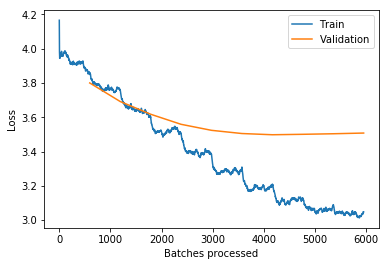

In [22]:
learn_lm.recorder.plot_losses()

In [25]:
learn_lm.save('fine_tuned')

In [26]:
learn_lm.save_encoder('fine_tuned_enc')

Fine tuned models *fit_head*, *fine_tuned* and *fine_tuned_enc* are saved in default `path/models` folder

Numeralized text and the integer to string dictionary are saved in user defined `path/tmp_lm` folder 

## Classifier

In [27]:
bs = 48

In [28]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [29]:
def precision(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()

In [30]:
def recall(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

In [31]:
data_clas = TextClasDataBunch.from_df(path, train_df=df_trn, valid_df=df_val, 
                                  vocab=data_lm.vocab, 
                                  text_cols='Narrative', 
                                  label_cols='Contributing Factors / Situations',
                                  label_delim='|',
                                  bs=bs)

In [32]:
data_clas.save('tmp_clas')

In [33]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.metrics = [accuracy_thresh, precision, recall]
learn.load_encoder('fine_tuned_enc')

In [34]:
learn.freeze()
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

Total time: 00:36
epoch  train_loss  valid_loss  accuracy_thresh  precision  recall  
1      0.239528    0.219730    0.907879         0.771040   0.441893  (00:36)



In [35]:
learn.save('first_factors')

In [ ]:
learn.load('first_factors')

In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7), wd=0.1)

Total time: 01:25
epoch  train_loss  valid_loss  accuracy_thresh  precision  recall  
1      0.226213    0.217303    0.909732         0.756436   0.501886  (00:42)
2      0.216116    0.214490    0.909625         0.739172   0.519424  (00:42)



In [37]:
learn.save('second_factors')

In [ ]:
learn.load('second_factors')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1)

In [38]:
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()

/home/krasin/anaconda2/envs/fastai.1/lib/python3.6/site-packages/torch/nn/functional.py:1126: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Classifier models *first_factors* and *second_factors* are saved in default `path/models` folder

Numeralized text, labels and the integer to string dictionary are saved in user defined `path/tmp_clas` folder 

## Evaluate results

In [39]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [40]:
from sklearn.metrics import classification_report

In [41]:
f1_score(y_true, y_pred>0.35, average='micro')

0.6599488864549106

In [44]:
y_true = y_true.numpy()
scores = y_pred.numpy()

In [35]:
scores.shape, y_true.shape

((2935, 16), (2935, 16))

In [51]:
metrics = classification_report(y_true, scores>0.35, target_names=data_clas.valid_ds.classes)
print(metrics)

                                              precision    recall  f1-score   support

                         Equipment / Tooling       0.00      0.00      0.00        56
                                    Aircraft       0.79      0.92      0.85      1635
    ATC Equipment / Nav Facility / Buildings       0.00      0.00      0.00        60
           Environment - Non Weather Related       0.29      0.18      0.23       238
                                     Weather       0.61      0.60      0.60       270
                               Human Factors       0.73      0.88      0.80      1672
                                    Staffing       0.50      0.02      0.04        52
                               Logbook Entry       0.29      0.08      0.13        59
Incorrect / Not Installed / Unavailable Part       0.23      0.15      0.18        71
                          Airspace Structure       0.50      0.05      0.10        92
                                   Procedure       0.